# **Data Science for Business - Group Project Part 2**



---

## 1.  **Data Augmentation** 

We are using the real time augmentation tool from keras which applies transformations on-the-fly during training, saving storage space. We have chosen to augment data by:
1. Shifting Vertically and Horizontally the digit as they are not always perfectly centered.
2. Zoom or Dezoom
3. Change a little bit the angle of the digit in the image
4. Make the blue and Red channel vary as from one image to another the reflet are differents 

In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os


# Custom function for color shifting
def color_shift(image):
    """Applies a random shift to the red and blue channels."""
    red_shift = np.random.uniform(-30, 30)  
    blue_shift = np.random.uniform(-30, 30)  
    image[..., 0] = np.clip(image[..., 0] + red_shift, 0, 255)  
    image[..., 2] = np.clip(image[..., 2] + blue_shift, 0, 255)  
    return image

datagen = ImageDataGenerator(
    rotation_range=15,         # Random rotation (degrees)
    width_shift_range=0.05,    # Horizontal translation (fraction of total width)
    height_shift_range=0.05,   # Vertical translation (fraction of total height)
    shear_range=0.2,           # Shear intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.05,           # Random zoom
    horizontal_flip=False,     
    fill_mode='nearest',        # Fill pixels after transformation
    preprocessing_function = color_shift  
)

Let's check what is actually happening in our data augmentation:

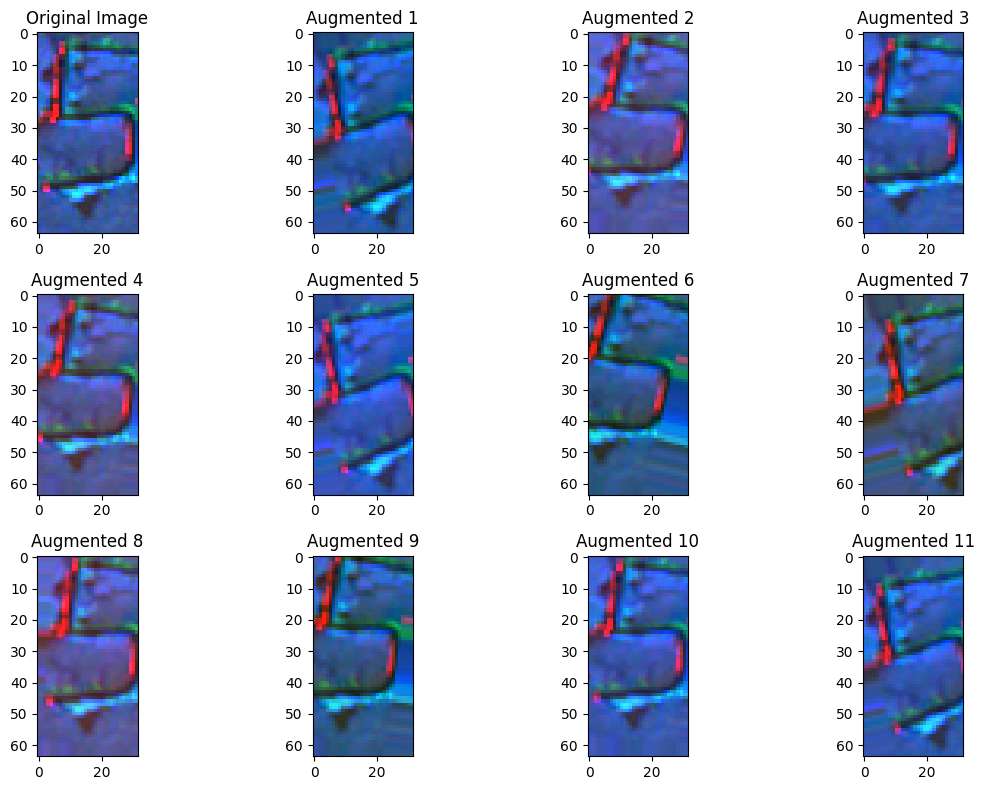

In [2]:
image_path = './Character_Images/sample_00000.png'

# Load the sample image
img = load_img(image_path, target_size=(64, 32)) 
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

plt.figure(figsize=(12, 8))
plt.subplot(3, 4, 1)
plt.imshow(img_array[0].astype('uint8')) 
plt.title("Original Image")

# Apply standard augmentations and custom color shift
for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
    if i >= 11:  # Generate only 11 augmented images
        break
    augmented_image = batch[0].astype('uint8') 
    plt.subplot(3, 4, i + 2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented {i+1}")

plt.tight_layout()
plt.show()

---
---

## 2.  **Model training** 

First let's split the data in a training and a testing set. As we have a lot of data available we chose to have the following proportion: 80% for the training and 20% for the testing.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

labels_file = './Labels.txt'
labels_df = pd.read_csv(labels_file, header=None, names=['Image', 'Label'])

# Append .png in the label file to match the name in the Character_Image folder 
def ensure_png_extension(filename):
    return filename if filename.endswith('.png') else f"{filename}.png"

labels_df['Image'] = labels_df['Image'].apply(ensure_png_extension)

# Remove leading/trailing spaces from labels
labels_df['Label'] = labels_df['Label'].str.strip()
# Save the updated Labels DataFrame back to the file
labels_df.to_csv(labels_file, index=False, header=False)

# Create a mapping from labels to integers
label_to_int = {label: idx for idx, label in enumerate(sorted(labels_df['Label'].unique()))}
int_to_label = {v: k for k, v in label_to_int.items()}  # Reverse mapping for reference

print("Label to integer mapping:", label_to_int)

# Update the DataFrame to use integer labels
labels_df['Label'] = labels_df['Label'].map(label_to_int)
# Split into training and validation sets (80% train, 20% val)
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=7, stratify=labels_df['Label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Print the number of samples per class in the training set
print("\nNumber of samples per class in the training set:")
print(train_df['Label'].value_counts())


Label to integer mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'C': 10, 'E': 11, 'X': 12}
Training samples: 59954
Validation samples: 14989

Number of samples per class in the training set:
Label
5     15018
0      7684
8      7053
6      6672
1      4522
2      4071
3      3702
4      3285
7      2824
9      2606
12      889
10      816
11      812
Name: count, dtype: int64


In [4]:
print(labels_df)

                  Image  Label
0      sample_00000.png      5
1      sample_00001.png      5
2      sample_00002.png      8
3      sample_00003.png      5
4      sample_00004.png      9
...                 ...    ...
74938  sample_74938.png      6
74939  sample_74939.png      0
74940  sample_74940.png      3
74941  sample_74941.png      2
74942  sample_74942.png      9

[74943 rows x 2 columns]


We can see that the Dataset is unbalanced and have very litle amount of Letter compared to the digit 5. To avoid overfitting on the number 5 we will do data augmentation proportionnaly to the number of element in each class in order to have a balanced dataset. 

In [5]:
num_classes = 13

# Calculate class frequencies
class_counts = train_df['Label'].value_counts().to_dict()
max_count = max(class_counts.values())  # Maximum count of any class

import math

# Calculate augmentation multipliers for each class with rounding up
augment_multipliers = {cls: math.ceil(max_count*2 / count) for cls, count in class_counts.items()}
print(f"Augmentation multipliers per class (rounded up): {augment_multipliers}")

# Check the shape and head of the DataFrame
print("DataFrame shape:", train_df.shape)
print("DataFrame head:")
print(train_df.head())

# Check for duplicates
print("Number of duplicate rows:", train_df.duplicated().sum())

# Check for missing values
print("Number of missing values per column:")
print(train_df.isnull().sum())

Augmentation multipliers per class (rounded up): {5: 2, 0: 4, 8: 5, 6: 5, 1: 7, 2: 8, 3: 9, 4: 10, 7: 11, 9: 12, 12: 34, 10: 37, 11: 37}
DataFrame shape: (59954, 2)
DataFrame head:
                  Image  Label
66805  sample_66805.png      8
60100  sample_60100.png      0
72551  sample_72551.png      6
67694  sample_67694.png      5
5496   sample_05496.png      0
Number of duplicate rows: 0
Number of missing values per column:
Image    0
Label    0
dtype: int64


In [ ]:
from collections import defaultdict
import numpy as np
from keras.utils import to_categorical
import os
from keras.preprocessing.image import img_to_array, load_img
import cv2

def balanced_batch_generator(df, images_path, datagen, num_classes, batch_size):
    """
    Generate balanced batches by including images from multiple classes in each batch.
    """
    while True:
        df = df.sample(frac=1).reset_index(drop=True)  # Shuffle DataFrame
        class_queues = defaultdict(list)

        # Group images by label
        for _, row in df.iterrows():
            class_queues[row['Label']].append(row)

        batch_images = []
        batch_labels = []

        while True:
            # Exit if all class queues are empty
            if all(len(rows) == 0 for rows in class_queues.values()):
                break

            # Alternate between classes
            for label, rows in class_queues.items():
                if not rows:
                    continue  # Skip if no images left for this class

                # Get a row for this label
                row = rows.pop(0)  # Remove the first row in the list
                img_name = row['Image']
                img_path = os.path.join(images_path, img_name)

                if not os.path.exists(img_path):
                    print(f"File not found: {img_path}, skipping row.")
                    continue

                # Load and preprocess the image
                img = load_img(img_path, target_size=(64, 32))
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)

                # Augment the image
                for augmented_img in datagen.flow(img_array, batch_size=1):
                    resized_img = cv2.resize(augmented_img[0], (32, 64))  # Resize to target dimensions
                    batch_images.append(resized_img)
                    batch_labels.append(label)

                    # Yield a batch when batch size is reached
                    if len(batch_images) == batch_size:
                        batch_labels_one_hot = to_categorical(batch_labels, num_classes=num_classes)
                        yield np.array(batch_images, dtype=np.float32), batch_labels_one_hot
                        batch_images, batch_labels = [], []  # Reset the batch
                    break

In [7]:
from keras.preprocessing.image import ImageDataGenerator

images_path = './Character_Images'

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Custom training generator with proportional augmentation
train_generator = balanced_batch_generator(train_df, images_path, datagen, num_classes, batch_size=32)

val_df['Label'] = val_df['Label'].astype(str)
# Validation generator (no augmentation)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=images_path,
    x_col='Image',
    y_col='Label',
    target_size=(64, 32),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
)


Found 14989 validated image filenames belonging to 13 classes.


In [8]:
batch_images, batch_labels = next(train_generator)
batch_class_counts = np.sum(batch_labels, axis=0)
print(f"Class counts in a single batch: {batch_class_counts}")

Class counts in a single batch: [3. 2. 2. 3. 2. 2. 3. 3. 3. 3. 2. 2. 2.]


We can now define and train the model. We have looked at equivalent problem and chose a type of model that was well adopded over the industry and that shown good result:

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

model = Sequential()

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(32, 64, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Layer 2
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Layer 3
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Convolution Layer 4
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Layer 5
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Global Average Pooling for better generalization
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))  # Assuming 13 classes
model.add(Activation('softmax'))

# Compile the model with an appropriate optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 64, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 32, 64)        2

In [ ]:
# Calculate steps per epoch for training and validation
train_steps = len(train_df) // 32
val_steps = len(val_generator)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=8,
    validation_data=val_generator,
    validation_steps=val_steps
)

# Save the model
model.save('OCR1.h5')

Epoch 1/8
1873/1873 [==============================] - 113s 60ms/step - loss: 1.0414 - accuracy: 0.8963 - val_loss: 10.3602 - val_accuracy: 0.0679
Epoch 2/8
1016/1873 [===============>..............] - ETA: 50s - loss: 0.6342 - accuracy: 0.9192

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#train_loss, train_accuracy = model.evaluate(train_generator)
#print(f"Train Loss: {train_loss}")
#print(f"Train Accuracy: {train_accuracy}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict all validation data
validation_steps = len(val_generator)
validation_predictions = model.predict(val_generator, steps=validation_steps)
validation_true_classes = val_generator.classes
validation_predicted_classes = np.argmax(validation_predictions, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(validation_true_classes, validation_predicted_classes, target_names=list(val_generator.class_indices.keys())))

# Confusion matrix
conf_matrix = confusion_matrix(validation_true_classes, validation_predicted_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(val_generator.class_indices.keys()), yticklabels=list(val_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import os

# Get misclassified indices
misclassified_indices = np.where(validation_true_classes != validation_predicted_classes)[0]

# Limit the number of images to display (e.g., 10)
num_to_display = min(len(misclassified_indices), 10)

# Display misclassified images
plt.figure(figsize=(20, 10))

for i, index in enumerate(misclassified_indices[:num_to_display]):
    # Get the file path
    img_path = os.path.join(images_path, val_df.iloc[index]['Image'])
    true_label = val_df.iloc[index]['Label']
    predicted_label = list(val_generator.class_indices.keys())[validation_predicted_classes[index]]
    
    # Load the image
    img = load_img(img_path, target_size=(64, 32))
    img_array = img_to_array(img)
    
    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_array.astype('uint8'))
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()